# HEAPML Project
## k-Nearest Neighbors

In [51]:
### GENERAL IMPORTS ###
import numpy as np
import pandas as pd
from statistics import mean 
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from itertools import cycle, combinations

### PYMATGEN/MATMINER IMPORTS ###
from matminer.featurizers import composition as cf
from matminer.featurizers.base import MultipleFeaturizer

### SKLEARN IMPORTS ###
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, cross_val_score, train_test_split, StratifiedKFold
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, auc, roc_curve, roc_auc_score
from sklearn.preprocessing import LabelBinarizer, label_binarize

### SKOMPTOMIZE IMPORTS ###
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.plots import plot_convergence

### 1. Import Featurized Data

In [14]:
feature_calculators = MultipleFeaturizer([cf.Stoichiometry(), cf.ElementProperty.from_preset('magpie')])
feature_labels = feature_calculators.feature_labels()

alloys = pd.read_csv('./data/featurized_alloys.csv')

display(alloys)

,formula,phase,composition_obj,0-norm,2-norm,3-norm,5-norm,7-norm,10-norm,MagpieData minimum Number,...,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber
0,AgAlCoCrCuNi,3,Ag1 Al1 Co1 Cr1 Cu1 Ni1,6,0.408248,0.302853,0.238495,0.215285,0.199372,13.0,...,1.548471,0.357311,0.476415,0.0,194.0,229.0,35.0,220.500000,8.833333,194.0
1,AgCoCrFeMnNi,1,Ag1 Co1 Cr1 Fe1 Mn1 Ni1,6,0.408248,0.302853,0.238495,0.215285,0.199372,24.0,...,2.110663,0.709140,0.746951,0.0,194.0,229.0,35.0,219.833333,9.555556,194.0
2,Al0.02CoCrFeMnNi,1,Al0.02 Co1 Cr1 Fe1 Mn1 Ni1,6,0.445450,0.340633,0.274847,0.250697,0.233988,13.0,...,2.110663,0.847577,0.782462,0.0,194.0,229.0,35.0,218.824701,10.617292,194.0
3,Al0.03CoCrFeMnNi,1,Al0.03 Co1 Cr1 Fe1 Mn1 Ni1,6,0.444586,0.339956,0.274300,0.250199,0.233523,13.0,...,2.110663,0.845892,0.782246,0.0,194.0,229.0,35.0,218.836978,10.605947,194.0
4,Al0.04CoCrFeMnNi,1,Al0.04 Co1 Cr1 Fe1 Mn1 Ni1,6,0.443735,0.339282,0.273756,0.249702,0.233059,13.0,...,2.110663,0.844214,0.782026,0.0,194.0,229.0,35.0,218.849206,10.594608,194.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1068,Zr2.0TiHfVNb2.0,1,Zr2 Ti1 Hf1 V1 Nb2,5,0.473804,0.381200,0.331220,0.315980,0.306266,22.0,...,0.000023,0.000003,0.000006,0.0,194.0,229.0,35.0,209.000000,17.142857,194.0
1069,ZrTiHfCuNiFe,1,Zr1 Ti1 Hf1 Cu1 Ni1 Fe1,6,0.408248,0.302853,0.238495,0.215285,0.199372,22.0,...,2.110663,0.451013,0.601344,0.0,194.0,229.0,35.0,210.166667,16.166667,194.0
1070,ZrTiHfNb0.5Mo0.5,1,Zr1 Ti1 Hf1 Nb0.5 Mo0.5,5,0.467707,0.370312,0.312720,0.292700,0.279049,22.0,...,0.000023,0.000006,0.000008,0.0,194.0,229.0,35.0,202.750000,13.125000,194.0
1071,ZrTiHfNb0.5Ta0.5,1,Zr1 Ti1 Hf1 Nb0.5 Ta0.5,5,0.467707,0.370312,0.312720,0.292700,0.279049,22.0,...,0.000023,0.000006,0.000008,0.0,194.0,229.0,35.0,202.750000,13.125000,194.0


### 2. Generate Dataset
*Note: the formula, phase and composition_obj columns are removed from $X$*

In [15]:
# Choose training columns from dataframe
x_cols = [c for c in alloys.columns if c not in ['formula', 'phase', 'composition_obj']]

y = alloys['phase'].values
X = alloys[x_cols]

# Split training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0, stratify=y)

display(X)

,0-norm,2-norm,3-norm,5-norm,7-norm,10-norm,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,...,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber
0,6,0.408248,0.302853,0.238495,0.215285,0.199372,13.0,47.0,34.0,28.000000,...,1.548471,0.357311,0.476415,0.0,194.0,229.0,35.0,220.500000,8.833333,194.0
1,6,0.408248,0.302853,0.238495,0.215285,0.199372,24.0,47.0,23.0,29.500000,...,2.110663,0.709140,0.746951,0.0,194.0,229.0,35.0,219.833333,9.555556,194.0
2,6,0.445450,0.340633,0.274847,0.250697,0.233988,13.0,28.0,15.0,25.948207,...,2.110663,0.847577,0.782462,0.0,194.0,229.0,35.0,218.824701,10.617292,194.0
3,6,0.444586,0.339956,0.274300,0.250199,0.233523,13.0,28.0,15.0,25.922465,...,2.110663,0.845892,0.782246,0.0,194.0,229.0,35.0,218.836978,10.605947,194.0
4,6,0.443735,0.339282,0.273756,0.249702,0.233059,13.0,28.0,15.0,25.896825,...,2.110663,0.844214,0.782026,0.0,194.0,229.0,35.0,218.849206,10.594608,194.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1068,5,0.473804,0.381200,0.331220,0.315980,0.306266,22.0,72.0,50.0,39.857143,...,0.000023,0.000003,0.000006,0.0,194.0,229.0,35.0,209.000000,17.142857,194.0
1069,6,0.408248,0.302853,0.238495,0.215285,0.199372,22.0,72.0,50.0,36.166667,...,2.110663,0.451013,0.601344,0.0,194.0,229.0,35.0,210.166667,16.166667,194.0
1070,5,0.467707,0.370312,0.312720,0.292700,0.279049,22.0,72.0,50.0,43.875000,...,0.000023,0.000006,0.000008,0.0,194.0,229.0,35.0,202.750000,13.125000,194.0
1071,5,0.467707,0.370312,0.312720,0.292700,0.279049,22.0,73.0,51.0,47.750000,...,0.000023,0.000006,0.000008,0.0,194.0,229.0,35.0,202.750000,13.125000,194.0


### 3. Train Model
`random_state` parameter is set to 0 in order to ensure reproducibility of results.

In [16]:
knn = KNeighborsClassifier(n_jobs=-1)

knn.fit(X_train, y_train)

KNeighborsClassifier(n_jobs=-1)

### 4. Evaluate Model

In [17]:
y_pred = knn.predict(X_test)

print('Precision: %.6f' % precision_score(y_test, y_pred, average='weighted'))
print('Recall: %.6f' % recall_score(y_test, y_pred, average='weighted'))
print('F1: %.6f' % f1_score(y_test, y_pred, average='weighted'))

Precision: 0.642408
Recall: 0.659155
F1: 0.643358


### 5. Feature Selection

In [18]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
knn = KNeighborsClassifier(n_jobs=-1)

sfscv = SequentialFeatureSelector(estimator=knn, n_features_to_select="auto", tol=-0.0001, direction="backward", scoring="f1_weighted", cv=cv, n_jobs=-1)
sfscv.fit(X_train, y_train)

selected_features = sfscv.get_feature_names_out()

mean_f1_score = mean(cross_val_score(knn, X_train, y_train, cv=cv, scoring='f1_weighted'))
print(mean_f1_score)

0.6058568454167416


### 6. Regenerate Dataset 

In [19]:
x_cols = [c for c in alloys.columns if c in selected_features]

y = alloys['phase'].values
X = alloys[x_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

print(selected_features)

display(X)

['MagpieData maximum Number' 'MagpieData range Number'
 'MagpieData mode Number' 'MagpieData minimum MendeleevNumber'
 'MagpieData mean MendeleevNumber' 'MagpieData mode MendeleevNumber'
 'MagpieData maximum AtomicWeight' 'MagpieData range AtomicWeight'
 'MagpieData mean AtomicWeight' 'MagpieData minimum MeltingT'
 'MagpieData maximum MeltingT' 'MagpieData avg_dev MeltingT'
 'MagpieData range Column' 'MagpieData minimum CovalentRadius'
 'MagpieData maximum CovalentRadius' 'MagpieData mean CovalentRadius'
 'MagpieData avg_dev CovalentRadius' 'MagpieData mode CovalentRadius'
 'MagpieData range NdValence' 'MagpieData mean NdValence'
 'MagpieData range NValence' 'MagpieData mean NValence'
 'MagpieData mode NValence' 'MagpieData maximum NdUnfilled'
 'MagpieData range NdUnfilled' 'MagpieData mean NdUnfilled'
 'MagpieData minimum NUnfilled' 'MagpieData range NUnfilled'
 'MagpieData mode NUnfilled' 'MagpieData maximum GSvolume_pa'
 'MagpieData range GSvolume_pa' 'MagpieData mode GSvolume_pa'
 

,MagpieData maximum Number,MagpieData range Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,MagpieData mean MendeleevNumber,MagpieData mode MendeleevNumber,MagpieData maximum AtomicWeight,MagpieData range AtomicWeight,MagpieData mean AtomicWeight,MagpieData minimum MeltingT,...,MagpieData range NUnfilled,MagpieData mode NUnfilled,MagpieData maximum GSvolume_pa,MagpieData range GSvolume_pa,MagpieData mode GSvolume_pa,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber
0,47.0,34.0,13.0,49.0,61.666667,49.0,107.868200,80.886661,61.336406,933.47,...,5.0,1.0,16.480,6.235,10.245,0.0,194.0,35.0,8.833333,194.0
1,47.0,23.0,24.0,49.0,56.666667,49.0,107.868200,55.872100,64.712323,1234.93,...,5.0,1.0,16.330,6.085,10.245,0.0,194.0,35.0,9.555556,194.0
2,28.0,15.0,24.0,49.0,55.071713,49.0,58.933195,31.951656,55.965213,933.47,...,4.0,2.0,16.480,6.235,10.245,0.0,194.0,35.0,10.617292,194.0
3,28.0,15.0,24.0,49.0,55.107356,49.0,58.933195,31.951656,55.907592,933.47,...,4.0,2.0,16.480,6.235,10.245,0.0,194.0,35.0,10.605947,194.0
4,28.0,15.0,24.0,49.0,55.142857,49.0,58.933195,31.951656,55.850199,933.47,...,4.0,2.0,16.480,6.235,10.245,0.0,194.0,35.0,10.594608,194.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1068,72.0,50.0,40.0,43.0,45.142857,44.0,178.490000,130.623000,92.222751,1941.00,...,1.0,7.0,23.195,10.185,18.180,0.0,194.0,35.0,17.142857,194.0
1069,72.0,50.0,22.0,43.0,52.000000,43.0,178.490000,130.623000,82.610900,1357.77,...,7.0,1.0,23.195,12.875,10.320,0.0,194.0,35.0,16.166667,194.0
1070,72.0,50.0,22.0,43.0,45.125000,43.0,178.490000,130.623000,103.003547,1941.00,...,2.0,8.0,23.195,7.505,16.690,0.0,194.0,35.0,13.125000,194.0
1071,73.0,51.0,22.0,43.0,44.875000,43.0,180.947880,133.080880,113.627032,1941.00,...,1.0,8.0,23.195,6.505,16.690,0.0,194.0,35.0,13.125000,194.0


### 7. Retrain Model

In [20]:
knn = KNeighborsClassifier(n_jobs=-1)

knn.fit(X_train, y_train)

KNeighborsClassifier(n_jobs=-1)

### 8. Re-evaluate Model


In [21]:
y_pred = knn.predict(X_test)

print('Precision: %.6f' % precision_score(y_test, y_pred, average='weighted'))
print('Recall: %.6f' % recall_score(y_test, y_pred, average='weighted'))
print('F1: %.6f' % f1_score(y_test, y_pred, average='weighted'))

Precision: 0.641372
Recall: 0.653521
F1: 0.638927


### 9. Hyperparameter Tuning

In [ ]:
space = [Integer(10**0, 718, 'log-uniform', name='n_neighbors'),
         Categorical(['uniform', 'distance'], name='weights'),
         Integer(1, 10**4, 'log-uniform', name='leaf_size'), 
         Integer(1, 2, 'uniform', name='p')]

In [ ]:
@use_named_args(space)
def objective(**params):
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    knn = KNeighborsClassifier(n_jobs=-1)
    knn.set_params(**params)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    score = f1_score(y_test, y_pred, average='weighted')
    return 1.0 - score

class tqdm_skopt(object):
    def __init__(self, **kwargs):
        self._bar = tqdm(**kwargs)
        
    def __call__(self, res):
        self._bar.update()

c:\Users\sarmi\.virtualenvs\heapml-XIgJAMJ7\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\sarmi\.virtualenvs\heapml-XIgJAMJ7\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\sarmi\.virtualenvs\heapml-XIgJAMJ7\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\sarmi\.virtualenvs\heapml-XIgJAMJ7\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\sarmi\.virtualenvs\heapml-XIgJAMJ7\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been eval

[14, 'distance', 1, 1]
0.6956788030474049


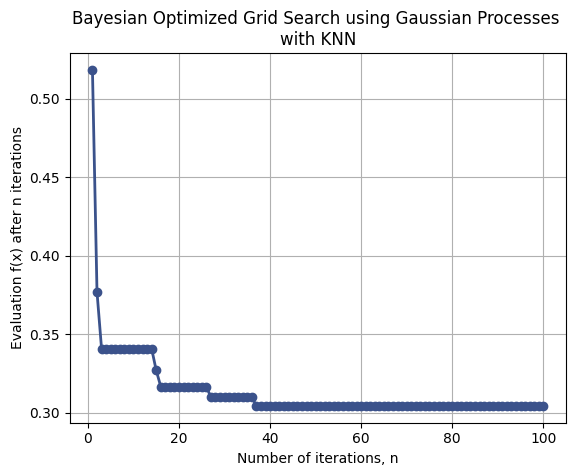

In [ ]:
n_calls = 100
result = gp_minimize(objective,
                     space,
                     n_calls=n_calls,
                     random_state=0)

print(result.x)
print(1-result.fun)
plot_convergence(result)
plt.xlabel("Number of iterations, n")
plt.ylabel("Evaluation f(x) after n iterations")
plt.title("Bayesian Optimized Grid Search using Gaussian Processes \nwith KNN")
plt.savefig("graphs/gp_knn.png")

### 10. Retrain and Evaluate Model

Precision: 0.703573
Recall: 0.704225
F1: 0.695679


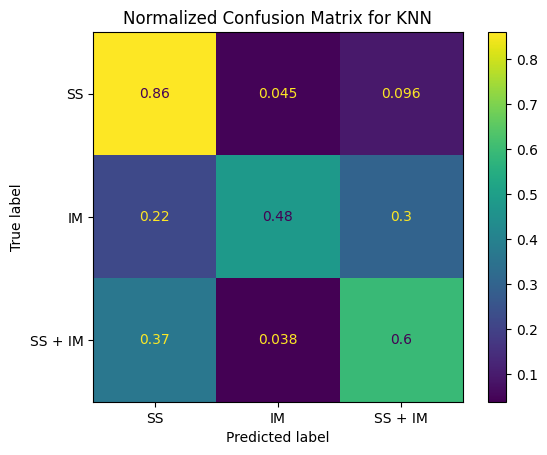

In [28]:
knn = KNeighborsClassifier(n_neighbors=14,
                           weights="distance",
                           leaf_size=1,
                           p=1,
                           n_jobs=-1)

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print('Precision: %.6f' % precision_score(y_test, y_pred, average='weighted'))
print('Recall: %.6f' % recall_score(y_test, y_pred, average='weighted'))
print('F1: %.6f' % f1_score(y_test, y_pred, average='weighted'))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true', display_labels=['SS', 'IM', 'SS + IM'])
plt.title("Normalized Confusion Matrix for KNN")
plt.savefig("graphs/cm_knn.png")

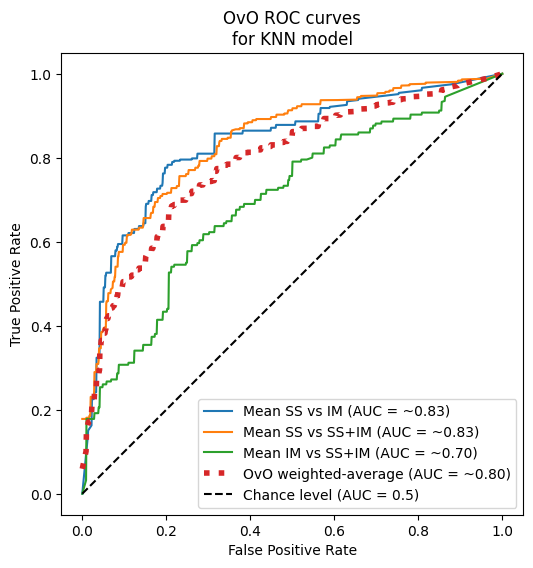

: 

In [52]:
class_labels = ["SS", "IM", "SS+IM"]
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

fpr_grid = np.linspace(0.0, 1.0, 1000)

pair_list = list(combinations(np.unique(y), 2))

pair_scores = []
mean_tpr = dict()

for ix, (label_a, label_b) in enumerate(pair_list):

    a_mask = y_test == label_a
    b_mask = y_test == label_b
    ab_mask = np.logical_or(a_mask, b_mask)

    a_true = a_mask[ab_mask]
    b_true = b_mask[ab_mask]

    idx_a = np.flatnonzero(label_binarizer.classes_ == label_a)[0]
    idx_b = np.flatnonzero(label_binarizer.classes_ == label_b)[0]

    fpr_a, tpr_a, _ = roc_curve(a_true, y_score[ab_mask, idx_a])
    fpr_b, tpr_b, _ = roc_curve(b_true, y_score[ab_mask, idx_b])

    mean_tpr[ix] = np.zeros_like(fpr_grid)
    mean_tpr[ix] += np.interp(fpr_grid, fpr_a, tpr_a)
    mean_tpr[ix] += np.interp(fpr_grid, fpr_b, tpr_b)
    mean_tpr[ix] /= 2
    mean_score = auc(fpr_grid, mean_tpr[ix])
    pair_scores.append(mean_score)

macro_roc_auc_ovo = roc_auc_score(
    y_test,
    y_score,
    multi_class="ovo",
    average="weighted",
)

ovo_tpr = np.zeros_like(fpr_grid)

fig, ax = plt.subplots(figsize=(6, 6))
for ix, (label_a, label_b) in enumerate(pair_list):
    ovo_tpr += mean_tpr[ix]
    plt.plot(
        fpr_grid,
        mean_tpr[ix],
        label=f"Mean {class_labels[label_a-1]} vs {class_labels[label_b-1]} (AUC = ~{pair_scores[ix]:.2f})",
    )

ovo_tpr /= sum(1 for pair in enumerate(pair_list))

plt.plot(
    fpr_grid,
    ovo_tpr,
    label=f"OvO weighted-average (AUC = ~{macro_roc_auc_ovo:.2f})",
    linestyle=":",
    linewidth=4,
)
plt.plot([0, 1], [0, 1], "k--", label="Chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("OvO ROC curves\nfor KNN model")
plt.legend()
plt.savefig("graphs/ovo_roc_knn.png")
plt.show()